In [ ]:
# Packages used to generate the SHAP values and graphs

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import shap

In [ ]:
# ======================================
# Random Forest + Random Oversampling + SHAP Analysis as it has the best performace around other models
# ======================================



# ---------------- 6. SHAP Analysis ----------------
print("Computing SHAP values...")

# Background sample for TreeExplainer
background_size = min(2000, X_train_bal.shape[0])
rng = np.random.RandomState(42)
bg_idx = rng.choice(X_train_bal.shape[0], size=background_size, replace=False)
background = X_train_bal.iloc[bg_idx]

explainer = shap.TreeExplainer(rf, data=background, feature_perturbation="interventional",model_output="probability")

# Representative sample from test set
sample_size = min(5000, X_test.shape[0])
ts_idx = rng.choice(X_test.shape[0], size=sample_size, replace=False)
X_shap = X_test.iloc[ts_idx]

# --- Compute SHAP values ---
sv = explainer.shap_values(X_shap)

# Handle list or 3D array cases
if isinstance(sv, list):
    sv_class = sv[1] if len(sv) > 1 else sv[0]
elif len(sv.shape) == 3 and sv.shape[2] == 2:
    sv_class = sv[:, :, 1]  # positive class (fire=1)
else:
    sv_class = sv

print("✅ SHAP values shape:", sv_class.shape)

# ---------------- 7. Global Importance ----------------
abs_sv_class = np.abs(sv_class)
shap_abs_mean = np.mean(abs_sv_class, axis=0)

imp_df = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": shap_abs_mean
}).sort_values("mean_abs_shap", ascending=False)

imp_df.to_csv(os.path.join(OUT_DIR, "global_shap_importance.csv"), index=False)

# Bar chart (Top 20)
plt.figure(figsize=(8, 6))
top_k = 20
plot_df = imp_df.head(top_k).iloc[::-1]
plt.barh(plot_df["feature"], plot_df["mean_abs_shap"])
plt.xlabel("Mean |SHAP value|")
plt.title("Global SHAP Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "shap_global_bar_top20.png"), dpi=200)
plt.close()

print("✅ Global importance CSV and bar chart saved.")

# ---------------- 8. Beeswarm Summary Plot ----------------
plt.figure()
shap.summary_plot(sv_class, X_shap, show=False, plot_type="dot", max_display=20)
plt.title("SHAP Beeswarm Summary (Top 20 Features)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "shap_summary_beeswarm_top20.png"),
            dpi=200, bbox_inches="tight")
plt.close()

print("✅ Beeswarm summary plot saved.")

# ---------------- 9. Dependence Plots ----------------
top_feats = imp_df["feature"].head(6).tolist()
for f in top_feats:
    shap.dependence_plot(
        f,
        sv_class,
        X_shap,
        show=False,
        interaction_index=None
    )
    plt.title(f"SHAP Dependence Plot — {f}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"dependence_{f}.png"),
                dpi=200, bbox_inches="tight")
    plt.close()

print("✅ Dependence plots saved for:", top_feats)

# ---------------- Done ----------------
print("\nAll results saved in:", OUT_DIR)

### This are the final results and most dependencies sourced from the data

### Used only 5000 samples from the entire dataset due to the time constraint and storage of my laptop - And this is also one of the key method to do when you got huge dataset. Note huge as many big models but a simple dataset that actuall has a real value from pacific palisades

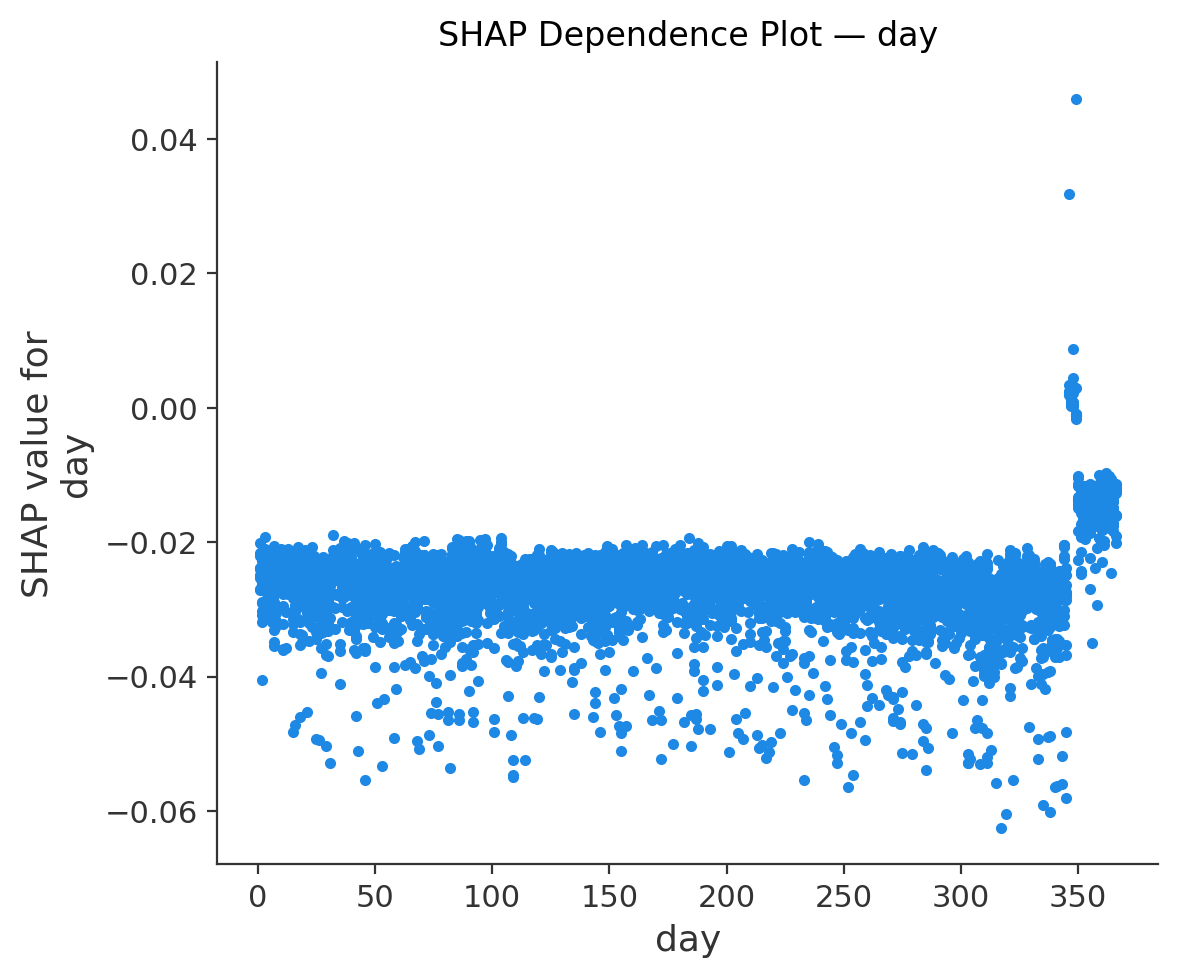 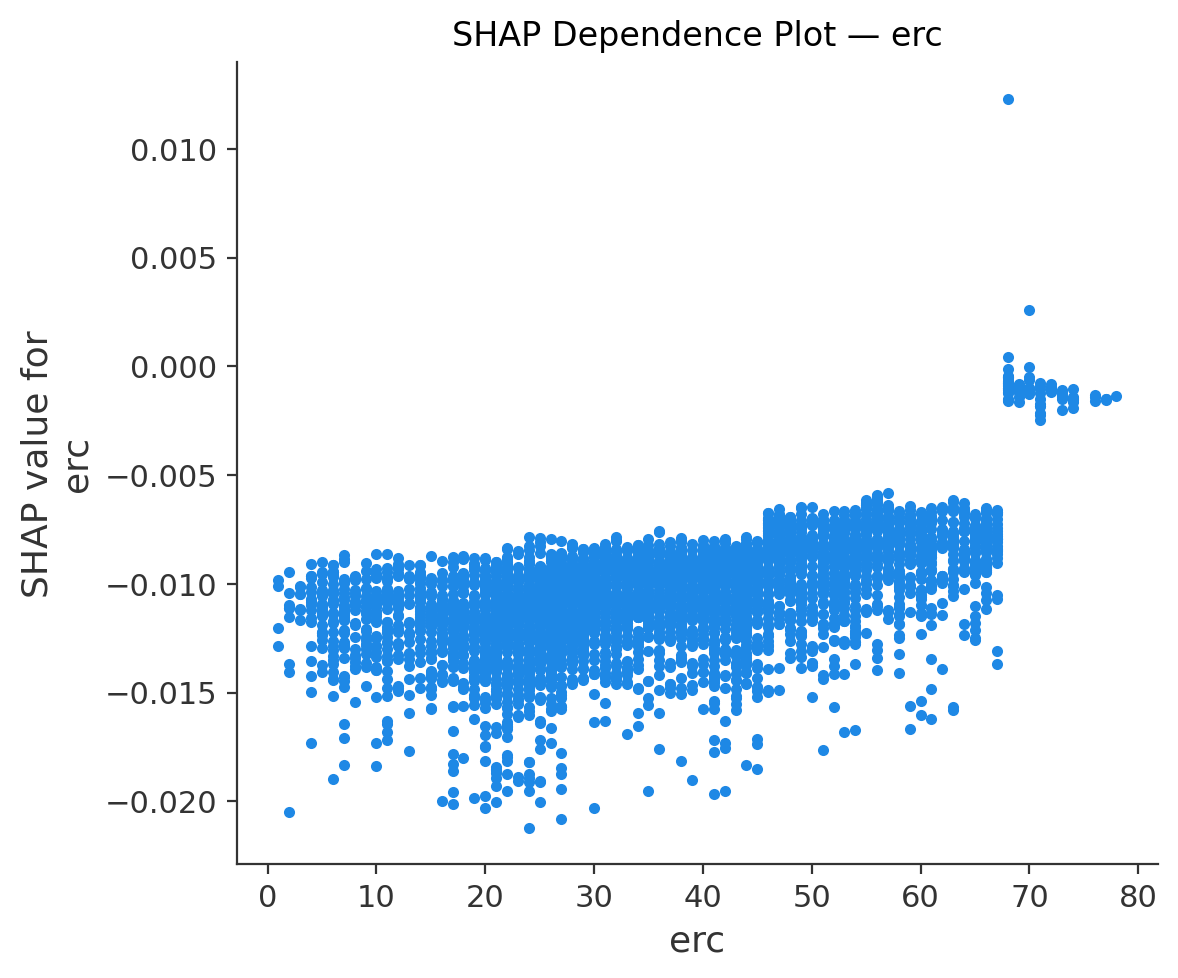 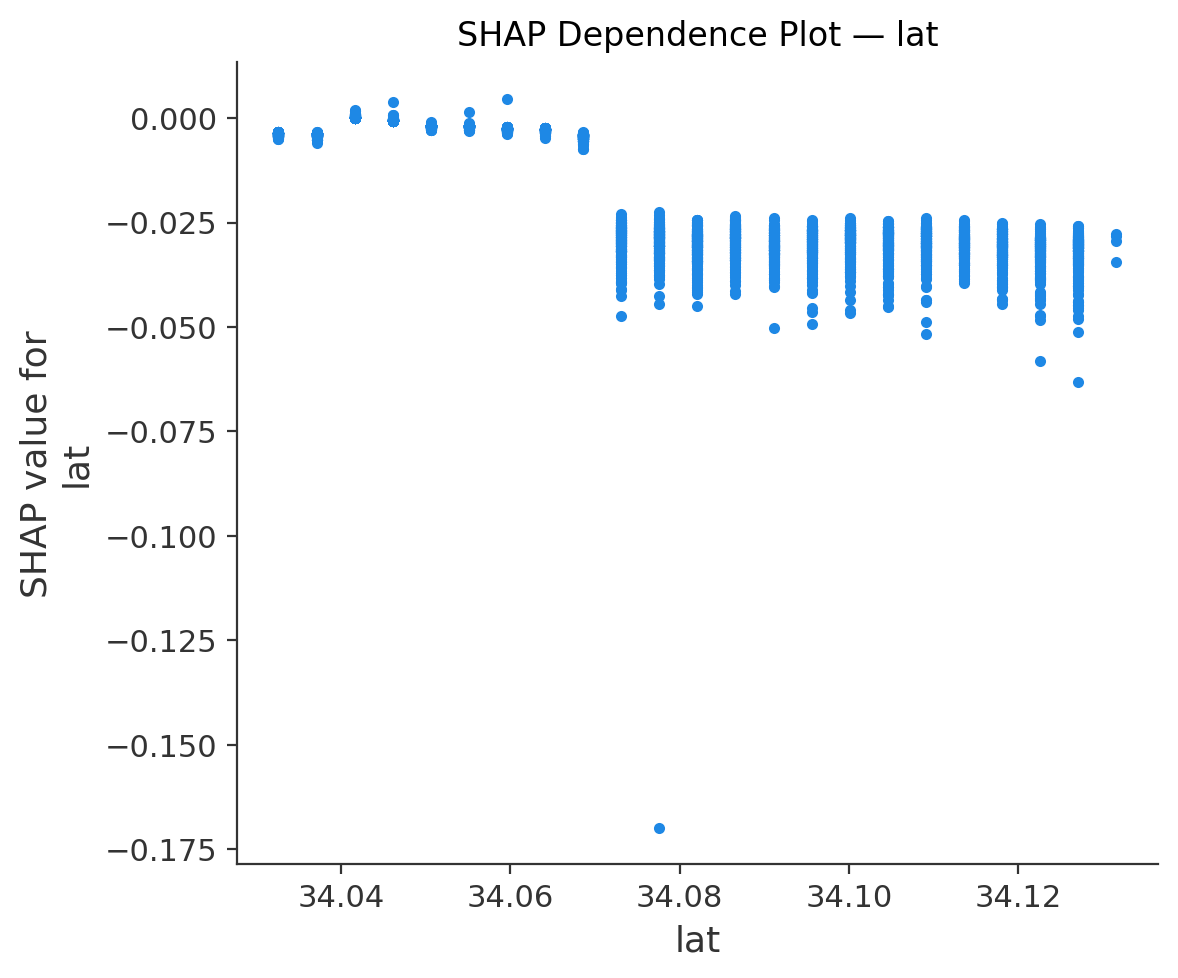 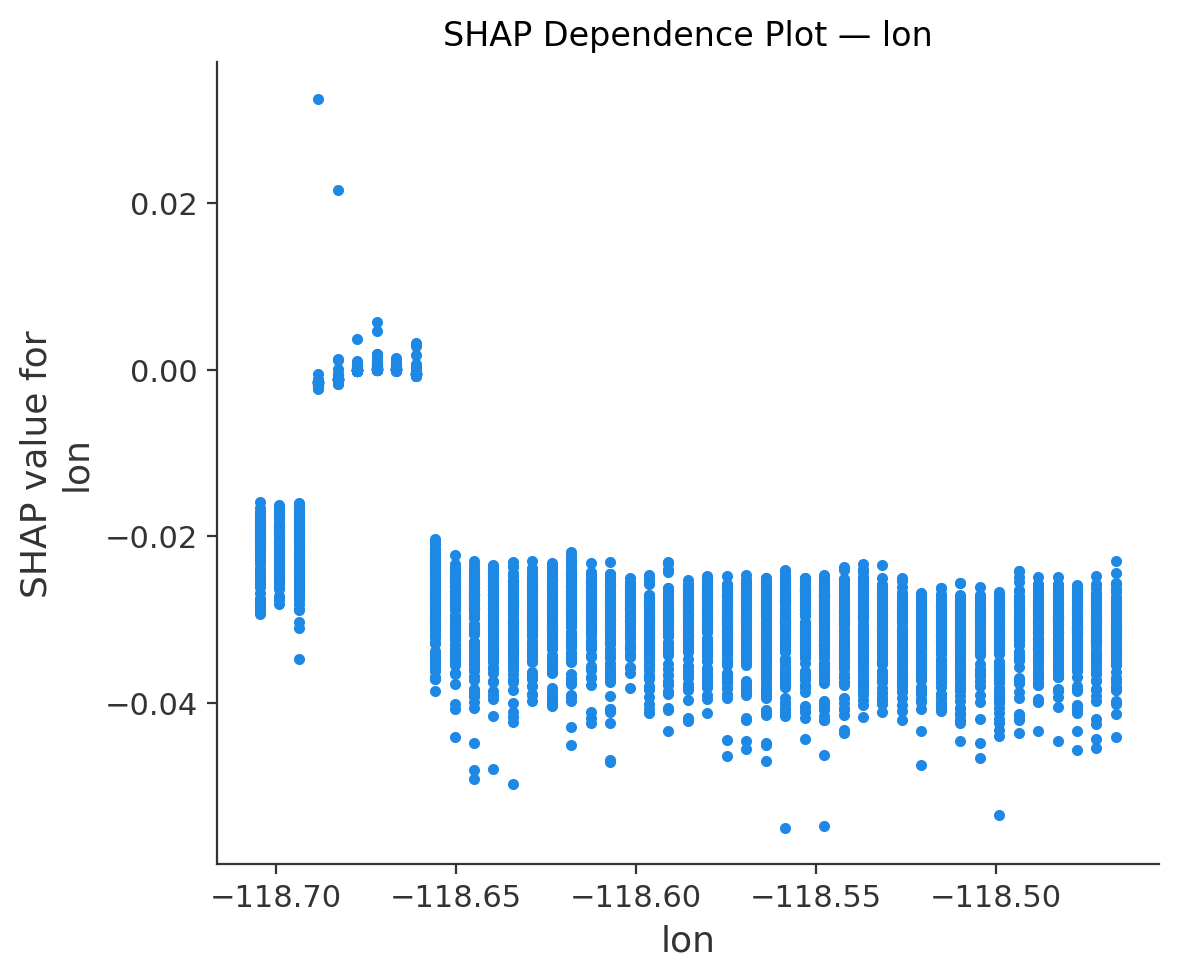 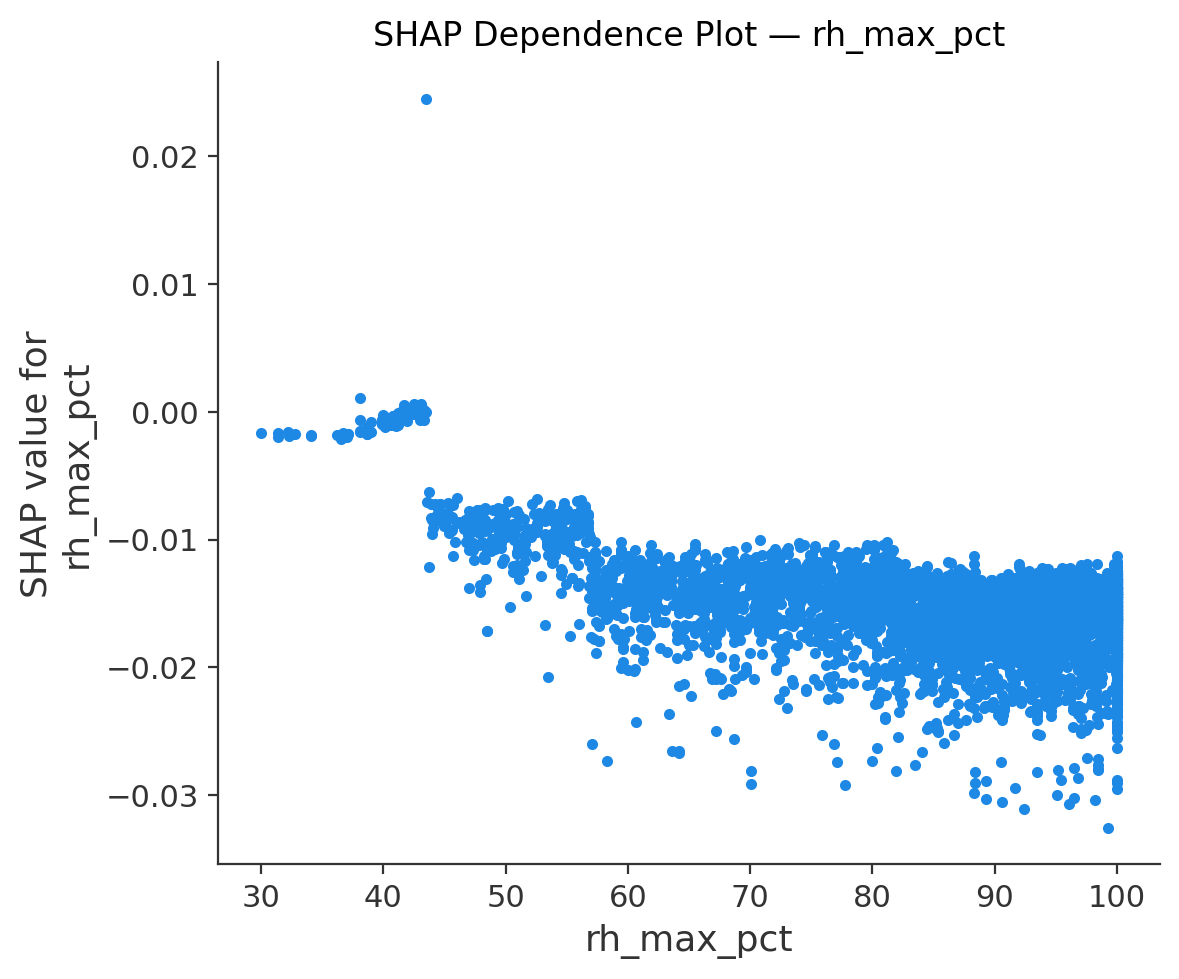 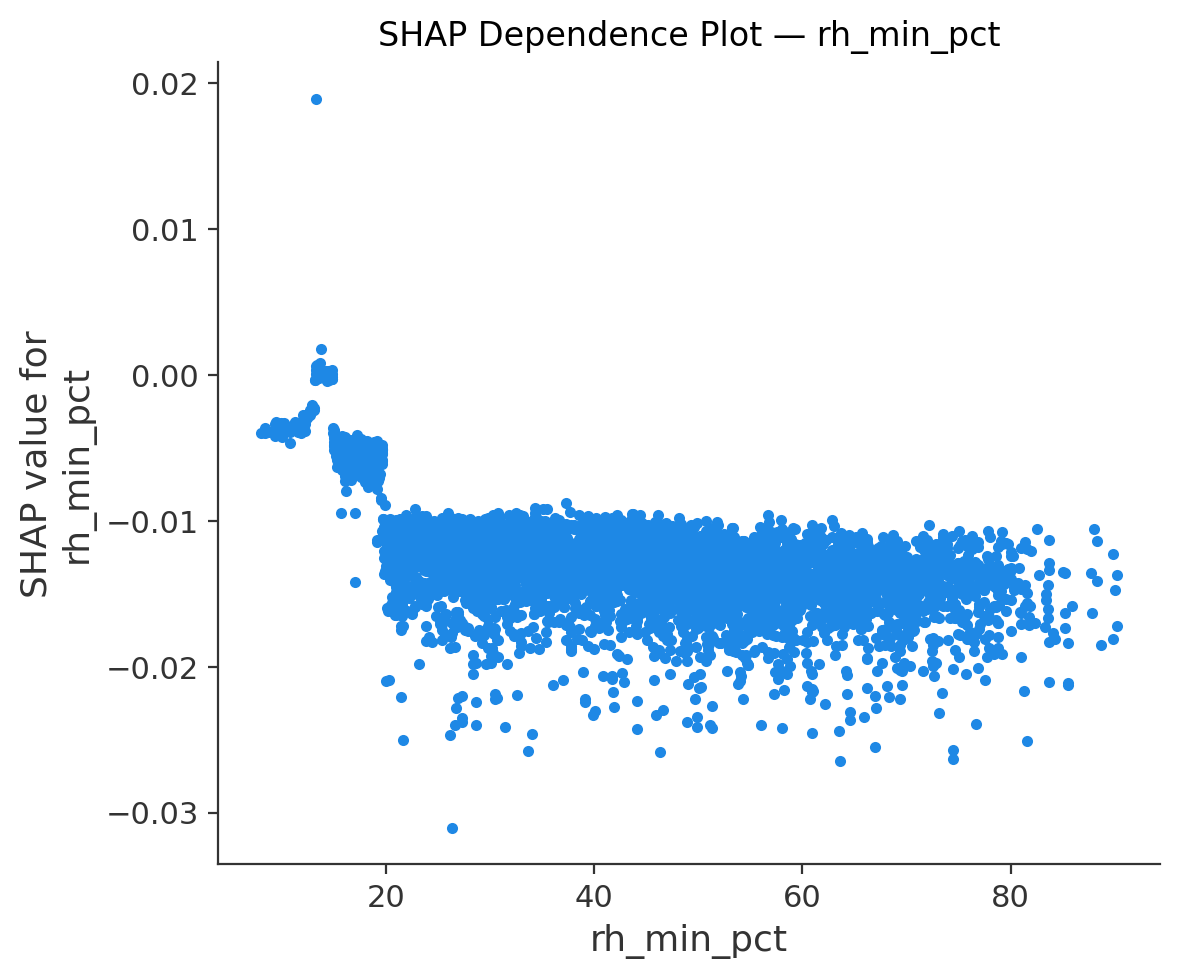 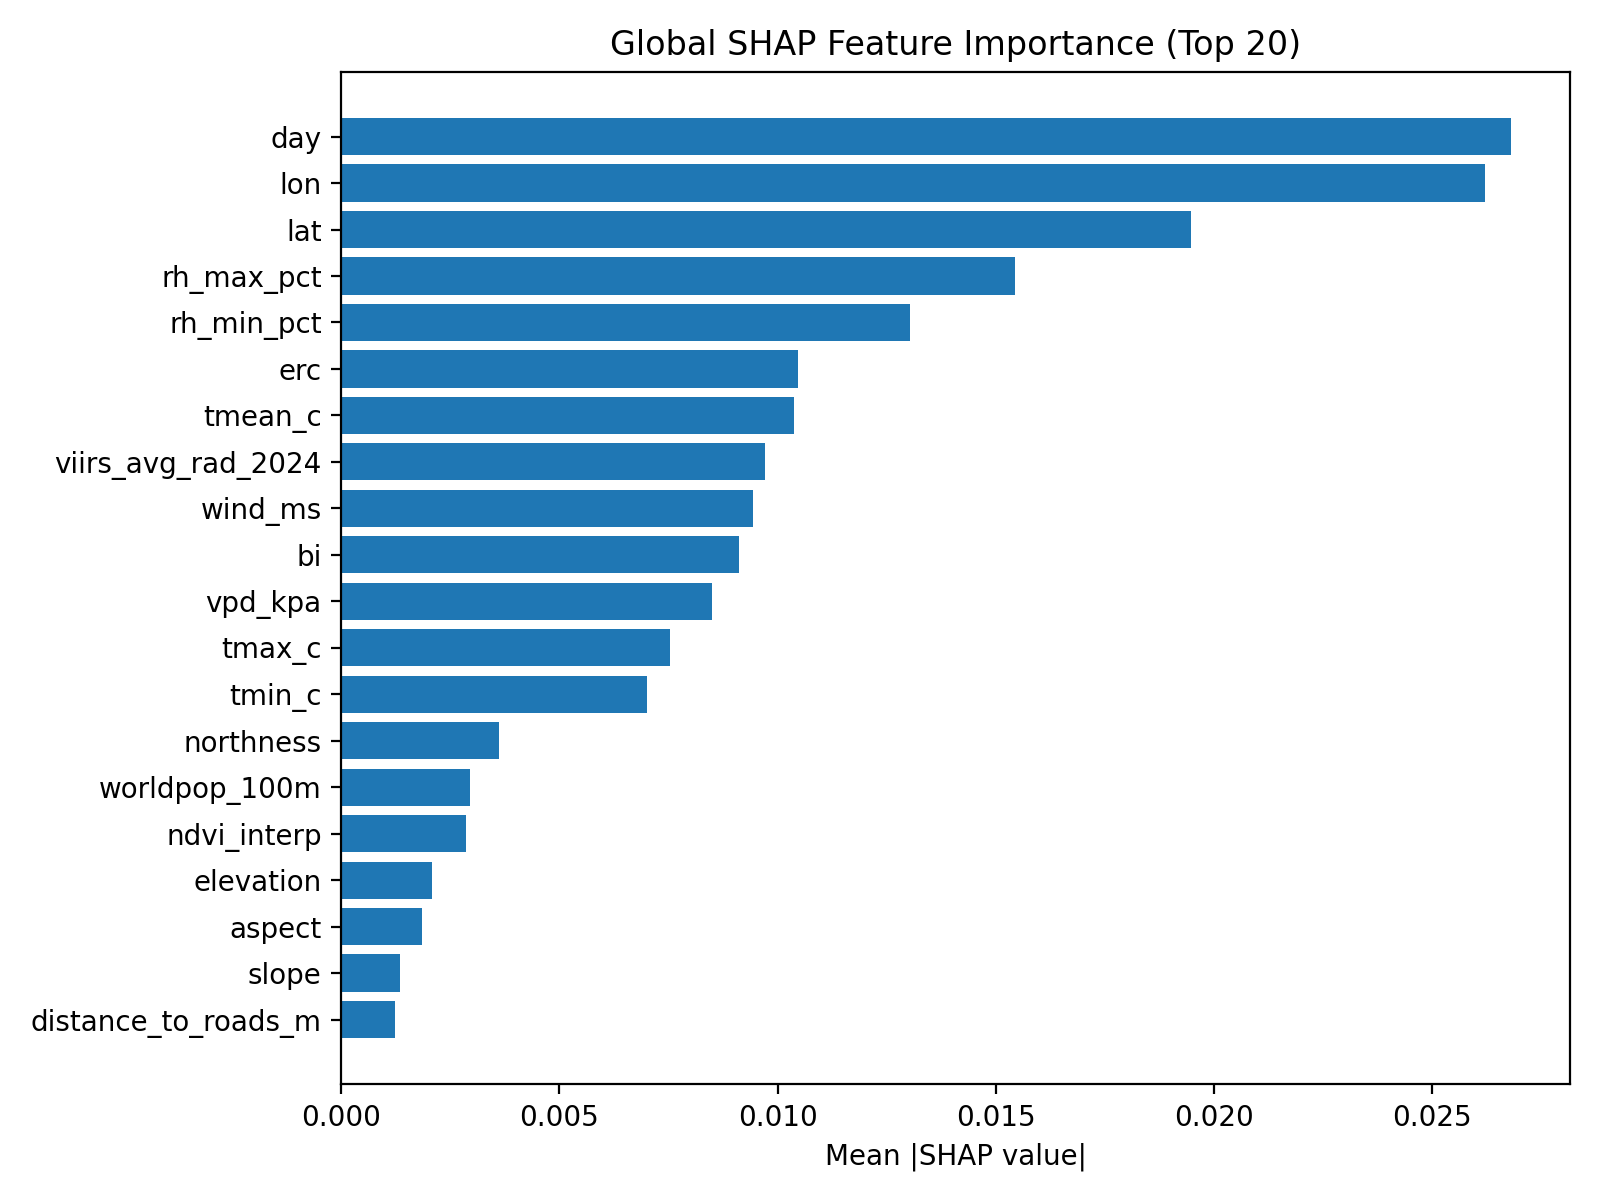 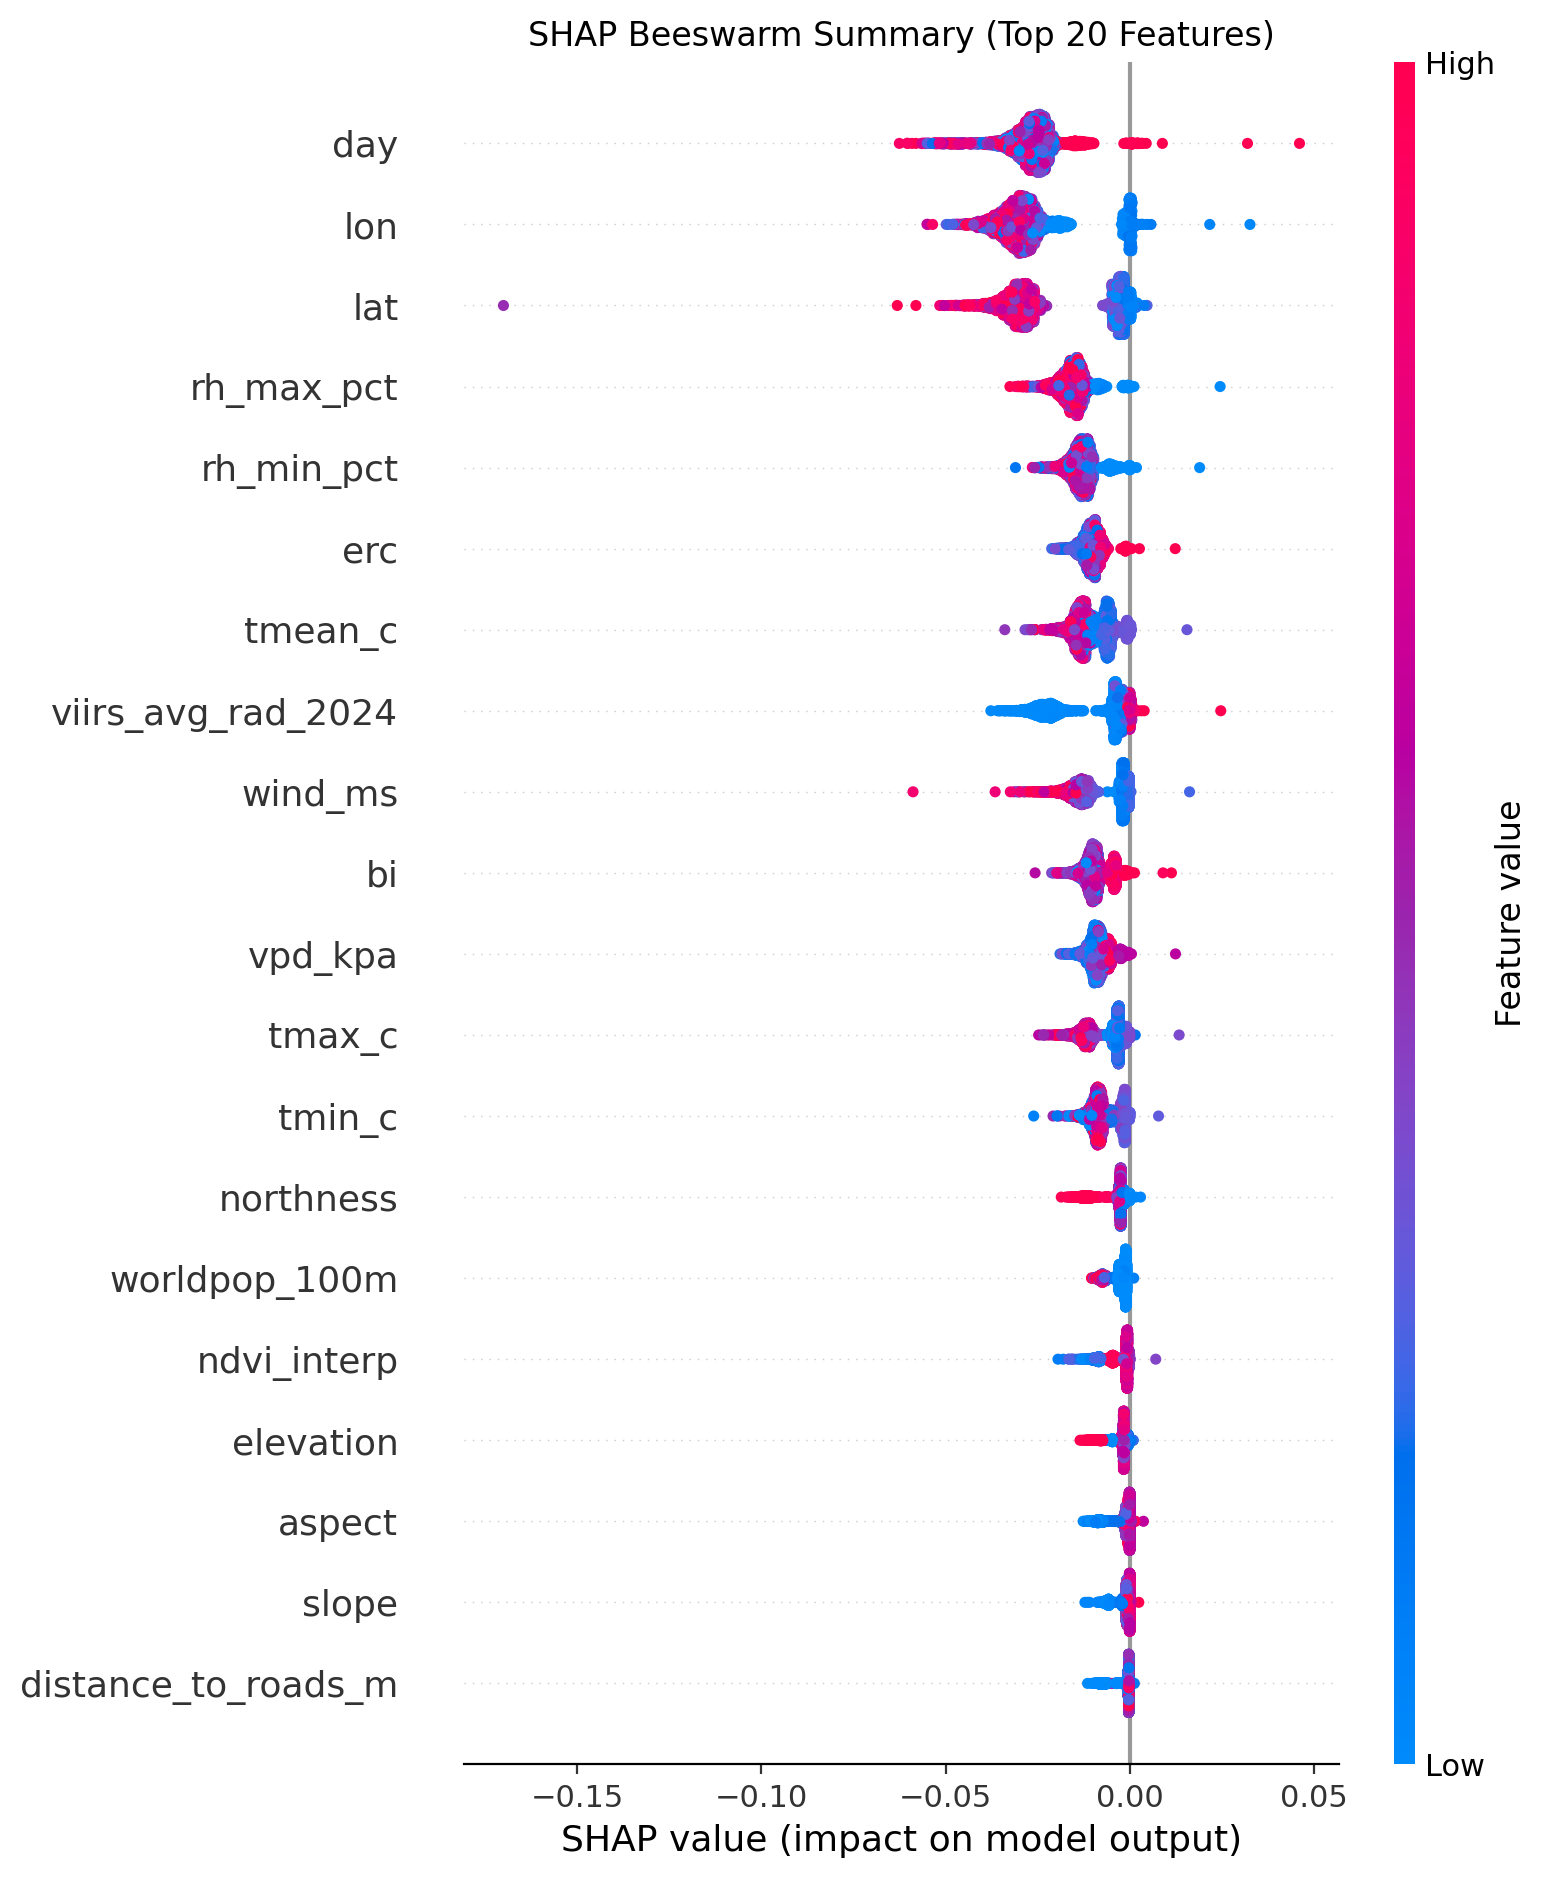